In [2]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, create_session
from sqlalchemy import create_engine, inspect



from sqlalchemy.ext.declarative import declarative_base

import json

In [3]:
# Read the csv file into a pandas DataFrame

flight_data_1Q = pd.read_csv('Delay_first_quarter1.csv')
flight_data_1Q.head()

,FL_DATE,DAY,MONTH,WEEKDAY,OP_CARRIER,AIRLINE,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_AIRPORT,ORIGIN_CITY,...,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,WEEKDAY_DUMMY,AIRLINE_DUMMY,DEPARTURE_DELAY_DUMMY,ARRIVAL_DELAY_DUMMY,DEPARTURE_DELAY_TEST,ARRIVAL_DELAY_TEST
0,2018-01-01,1,1,Monday,UA,United Airlines,2429,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,0.0,1,1,0,0,On Time,On Time
1,2018-01-01,1,1,Monday,UA,United Airlines,2041,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,116.0,1,1,1,1,Long Delay,Long Delay
2,2018-01-01,1,1,Monday,UA,United Airlines,1819,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,0.0,1,1,0,0,On Time,On Time
3,2018-01-01,1,1,Monday,UA,United Airlines,1740,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,0.0,1,1,1,0,Small Delay,On Time
4,2018-01-01,1,1,Monday,UA,United Airlines,1262,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,0.0,1,1,0,0,On Time,On Time


In [5]:
flight_data_1Q["ARRIVAL_DELAY_OVER_15_MINUTES"] = 1*np.ravel(flight_data_1Q["ARRIVAL_DELAY_TEST"] == "Long Delay")

In [6]:
flight_data_1Q = flight_data_1Q.loc[(flight_data_1Q["FL_DATE"] < "2018-02-01") & (flight_data_1Q["FL_DATE"] >= "2018-01-01"),:]

In [7]:
len(flight_data_1Q)

564537

In [8]:
flight_data_1Q.columns

Index(['FL_DATE', 'DAY', 'MONTH', 'WEEKDAY', 'OP_CARRIER', 'AIRLINE',
       'OP_CARRIER_FL_NUM', 'ORIGIN', 'ORIGIN_AIRPORT', 'ORIGIN_CITY',
       'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'EAST_COAST_ORIGIN', 'WEST_COAST_ORIGIN', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEPARTURE_TIME_OF_DAY', 'DEPARTURE_TIME_OF_DAY_DUMMY', 'DEP_DELAY',
       'DEPARTURE_DELAY', 'DEPARTURE_DELAY_OVER_15_MINUTES',
       'DEPARTURE_DELAY_OVER_30_MINUTES', 'DEPARTURE_DELAY_OVER_45_MINUTES',
       'DEPARTURE_DELAY_OVER_60_MINUTES', 'TAXI_OUT', 'WHEELS_OFF', 'AIR_TIME',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'WHEELS_ON',
       'TAXI_IN', 'DEST', 'DEST_AIRPORT', 'DEST_CITY', 'DEST_STATE',
       'DEST_LATITUDE', 'DEST_LONGITUDE', 'EAST_COAST_DEST', 'WEST_COAST_DEST',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARRIVAL_DELAY',
       'ARRIVAL_DELAY_OVER_15_MINUTES', 'ARRIVAL_DELAY_OVER_30_MINUTES',
       'ARRIVAL_DELAY_OVER_45_MINUTES', 'ARRIVAL_DELAY_OVER_60_M

In [9]:
flight_data_1Q = flight_data_1Q.drop(['FL_DATE', 'WEEKDAY', 'OP_CARRIER', 'AIRLINE', 'ORIGIN_AIRPORT', 'ORIGIN_CITY', 'ORIGIN_STATE', 'DEPARTURE_TIME_OF_DAY', 'DEPARTURE_DELAY', 'DEPARTURE_DELAY_TEST', 'ARRIVAL_DELAY_TEST', 'DEST_AIRPORT', 'DEST_CITY', 'DEST_STATE', 'ARRIVAL_TIME_OF_DAY', 'EAST_COAST_DEST', 'WEST_COAST_DEST', 'OP_CARRIER_FL_NUM'], axis=1)
            

In [10]:
flight_data_1Q.columns

Index(['DAY', 'MONTH', 'ORIGIN', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'EAST_COAST_ORIGIN', 'WEST_COAST_ORIGIN', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEPARTURE_TIME_OF_DAY_DUMMY', 'DEP_DELAY',
       'DEPARTURE_DELAY_OVER_15_MINUTES', 'DEPARTURE_DELAY_OVER_30_MINUTES',
       'DEPARTURE_DELAY_OVER_45_MINUTES', 'DEPARTURE_DELAY_OVER_60_MINUTES',
       'TAXI_OUT', 'WHEELS_OFF', 'AIR_TIME', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'DEST',
       'DEST_LATITUDE', 'DEST_LONGITUDE', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARRIVAL_DELAY', 'ARRIVAL_DELAY_OVER_15_MINUTES',
       'ARRIVAL_DELAY_OVER_30_MINUTES', 'ARRIVAL_DELAY_OVER_45_MINUTES',
       'ARRIVAL_DELAY_OVER_60_MINUTES', 'ARRIVAL_DELAY_OVER_60_MINUTES.1',
       'ARRIVAL_TIME_OF_DAY_DUMMY', 'CANCELLED', 'DIVERTED', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEEKDAY_DUMMY', 'AIRLINE_DUMMY', 'DEPARTURE_DELAY_DUMMY

In [11]:
# Use Pandas get_dummies to convert categorical data

### BEGIN SOLUTION
flight_data_1Q = pd.get_dummies(flight_data_1Q, columns = ["ORIGIN","DEST"])
flight_data_1Q.head()
### END SOLUTION

,DAY,MONTH,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,EAST_COAST_ORIGIN,WEST_COAST_ORIGIN,CRS_DEP_TIME,DEP_TIME,DEPARTURE_TIME_OF_DAY_DUMMY,DEP_DELAY,...,DEST_TWF,DEST_TXK,DEST_TYR,DEST_TYS,DEST_VLD,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YUM
0,1,1,40.6925,-74.16866,1,0,1517,1512.0,1,-5.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,40.6925,-74.16866,1,0,1657,1938.0,1,161.0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,40.6925,-74.16866,1,0,600,559.0,0,-1.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,40.6925,-74.16866,1,0,1855,1906.0,2,11.0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,40.6925,-74.16866,1,0,1150,1149.0,1,-1.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
print(flight_data_1Q.columns)

Index(['DAY', 'MONTH', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'EAST_COAST_ORIGIN', 'WEST_COAST_ORIGIN', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEPARTURE_TIME_OF_DAY_DUMMY', 'DEP_DELAY',
       ...
       'DEST_TWF', 'DEST_TXK', 'DEST_TYR', 'DEST_TYS', 'DEST_VLD', 'DEST_VPS',
       'DEST_WRG', 'DEST_XNA', 'DEST_YAK', 'DEST_YUM'],
      dtype='object', length=659)


In [14]:
flight_data_1Q = flight_data_1Q.copy()

In [15]:
#flight_data.1Q.columns.tolist()

list(flight_data_1Q.columns)

['DAY',
 'MONTH',
 'ORIGIN_LATITUDE',
 'ORIGIN_LONGITUDE',
 'EAST_COAST_ORIGIN',
 'WEST_COAST_ORIGIN',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEPARTURE_TIME_OF_DAY_DUMMY',
 'DEP_DELAY',
 'DEPARTURE_DELAY_OVER_15_MINUTES',
 'DEPARTURE_DELAY_OVER_30_MINUTES',
 'DEPARTURE_DELAY_OVER_45_MINUTES',
 'DEPARTURE_DELAY_OVER_60_MINUTES',
 'TAXI_OUT',
 'WHEELS_OFF',
 'AIR_TIME',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'DEST_LATITUDE',
 'DEST_LONGITUDE',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'ARRIVAL_DELAY',
 'ARRIVAL_DELAY_OVER_15_MINUTES',
 'ARRIVAL_DELAY_OVER_30_MINUTES',
 'ARRIVAL_DELAY_OVER_45_MINUTES',
 'ARRIVAL_DELAY_OVER_60_MINUTES',
 'ARRIVAL_DELAY_OVER_60_MINUTES.1',
 'ARRIVAL_TIME_OF_DAY_DUMMY',
 'CANCELLED',
 'DIVERTED',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEEKDAY_DUMMY',
 'AIRLINE_DUMMY',
 'DEPARTURE_DELAY_DUMMY',
 'ARRIVAL_DELAY_DUMMY',
 'ORIGIN_ABE',
 'ORIGIN_ABI',
 'ORIGIN_ABQ',


In [16]:
flight_data_1Q = flight_data_1Q.fillna(0)

In [17]:
# Assign X (data) and y (target)

### BEGIN SOLUTION
X =  flight_data_1Q[["DAY", "MONTH", "DEP_TIME", "EAST_COAST_ORIGIN", "WEST_COAST_ORIGIN", "DEPARTURE_DELAY_DUMMY", "DEPARTURE_TIME_OF_DAY_DUMMY",\
"CRS_DEP_TIME", "TAXI_OUT", "WHEELS_OFF", "AIR_TIME", "WHEELS_ON", "TAXI_IN", "DEPARTURE_TIME_OF_DAY_DUMMY", "DEP_DELAY", \
             "ARR_TIME", "ARRIVAL_TIME_OF_DAY_DUMMY", "CARRIER_DELAY", "CRS_ARR_TIME", \
      "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"]]
y = flight_data_1Q['ARR_DELAY'].values.reshape(-1, 1)
print(X.shape, y.shape)
### END SOLUTION

(564537, 23) (564537, 1)


In [18]:
# Split the data into training and testing

### BEGIN SOLUTION
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
### END SOLUTION

In [19]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

### BEGIN SOLUTION
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
### END SOLUTION

In [20]:
# Transform the training and testing data using the X_scaler and y_scaler models

### BEGIN SOLUTION
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
### END SOLUTION

In [21]:
# Create a LinearRegression model and fit it to the scaled training data

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
### END SOLUTION

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

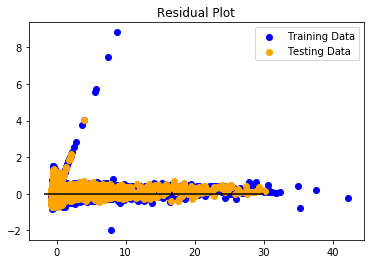

In [22]:
# Make predictions using the X_test_scaled data
# Plot y_test_scaled vs y_test_scaled
# Scatter plot y_test_scaled vs predictions

### BEGIN SOLUTION
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [23]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.0372445592328128, R2: 0.9638591505031994


In [24]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.04059133244975549, R2: 0.9606115559652328


In [25]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.03724455838504746, R2: 0.963859151325842


In [26]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.038080633781197665, R2: 0.9630478522882735


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [28]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
# Read the csv file into a pandas DataFrame

flight_data_1Q = pd.read_csv('Delay_first_quarter1.csv')
flight_data_1Q.head()

,FL_DATE,DAY,MONTH,WEEKDAY,OP_CARRIER,AIRLINE,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_AIRPORT,ORIGIN_CITY,...,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,WEEKDAY_DUMMY,AIRLINE_DUMMY,DEPARTURE_DELAY_DUMMY,ARRIVAL_DELAY_DUMMY,DEPARTURE_DELAY_TEST,ARRIVAL_DELAY_TEST
0,2018-01-01,1,1,Monday,UA,United Airlines,2429,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,0.0,1,1,0,0,On Time,On Time
1,2018-01-01,1,1,Monday,UA,United Airlines,2041,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,116.0,1,1,1,1,Long Delay,Long Delay
2,2018-01-01,1,1,Monday,UA,United Airlines,1819,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,0.0,1,1,0,0,On Time,On Time
3,2018-01-01,1,1,Monday,UA,United Airlines,1740,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,0.0,1,1,1,0,Small Delay,On Time
4,2018-01-01,1,1,Monday,UA,United Airlines,1262,EWR,Newark Liberty International Airport,Newark,...,0.0,0.0,0.0,0.0,1,1,0,0,On Time,On Time


In [241]:
flight_data_1Q["ARRIVAL_DELAY_OVER_15_MINUTES"] = 1*np.ravel(flight_data_1Q["ARRIVAL_DELAY_TEST"] == "Long Delay")

KeyError: 'ARRIVAL_DELAY_TEST'

In [31]:
flight_data_1Q=flight_data_1Q.fillna(0)

In [32]:
y = flight_data_1Q["ARRIVAL_DELAY"]
target_names = ["negative", "positive"]

In [33]:
# Use Pandas get_dummies to convert categorical data

### BEGIN SOLUTION
flight_data_1Q = pd.get_dummies(flight_data_1Q, columns = ["DEST"])
flight_data_1Q.head()
### END SOLUTION

,FL_DATE,DAY,MONTH,WEEKDAY,OP_CARRIER,AIRLINE,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_AIRPORT,ORIGIN_CITY,...,DEST_TWF,DEST_TXK,DEST_TYR,DEST_TYS,DEST_VLD,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YUM
0,2018-01-01,1,1,Monday,UA,United Airlines,2429,EWR,Newark Liberty International Airport,Newark,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,1,1,Monday,UA,United Airlines,2041,EWR,Newark Liberty International Airport,Newark,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-01,1,1,Monday,UA,United Airlines,1819,EWR,Newark Liberty International Airport,Newark,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-01,1,1,Monday,UA,United Airlines,1740,EWR,Newark Liberty International Airport,Newark,...,0,0,0,0,0,0,0,0,0,0
4,2018-01-01,1,1,Monday,UA,United Airlines,1262,EWR,Newark Liberty International Airport,Newark,...,0,0,0,0,0,0,0,0,0,0


In [34]:
X = flight_data_1Q.drop(["ARRIVAL_DELAY_OVER_60_MINUTES", "ARRIVAL_DELAY_OVER_45_MINUTES", "ARRIVAL_DELAY_OVER_30_MINUTES", "ARRIVAL_DELAY_OVER_15_MINUTES", "ARR_TIME", "WEEKDAY", "AIRLINE", "OP_CARRIER", "ORIGIN", "ORIGIN_AIRPORT", "ORIGIN_CITY", "ORIGIN_STATE", "DEPARTURE_TIME_OF_DAY", "DEST_AIRPORT", "DEST_CITY", "DEST_STATE", "ARRIVAL_TIME_OF_DAY", "ARRIVAL_DELAY_OVER_15_MINUTES", "FL_DATE"], axis=1)
X.head()

,DAY,MONTH,OP_CARRIER_FL_NUM,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,EAST_COAST_ORIGIN,WEST_COAST_ORIGIN,CRS_DEP_TIME,DEP_TIME,DEPARTURE_TIME_OF_DAY_DUMMY,...,DEST_TWF,DEST_TXK,DEST_TYR,DEST_TYS,DEST_VLD,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YUM
0,1,1,2429,40.6925,-74.16866,1,0,1517,1512.0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2041,40.6925,-74.16866,1,0,1657,1938.0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1819,40.6925,-74.16866,1,0,600,559.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1740,40.6925,-74.16866,1,0,1855,1906.0,2,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1262,40.6925,-74.16866,1,0,1150,1149.0,1,...,0,0,0,0,0,0,0,0,0,0


In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

k: 1, Train/Test Score: 1.000/0.917
k: 3, Train/Test Score: 0.956/0.909
k: 5, Train/Test Score: 0.935/0.900
k: 7, Train/Test Score: 0.921/0.891
k: 9, Train/Test Score: 0.909/0.883
k: 11, Train/Test Score: 0.898/0.877
k: 13, Train/Test Score: 0.890/0.870


In [47]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train, y_train)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [ ]:
knn=KNeighborsClassifiers(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
predictions = knn.predict(X_train_scaled)
print('k=5 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

In [44]:
# Model Accuracy
print('Test Acc: %.3f' % model.score(X_test, y_test))


NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [163]:
# Calculate classification report
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00    305007
    positive       1.00      1.00      1.00    115862

   micro avg       1.00      1.00      1.00    420869
   macro avg       1.00      1.00      1.00    420869
weighted avg       1.00      1.00      1.00    420869



In [ ]:
# Read from: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names
names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
df = pd.read_csv(import pandas as pd

    'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', names=names)

In [ ]:
# Note the entries `iris-virginica`
df.tail(5)

In [ ]:
# Step 0: Reformat data
data = df.values
X = data[:, 0:4]
y = data[:, 4]

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y)
encoded_y = label_encoder.transform(y)

In [ ]:
for label, original_class in zip(encoded_y, y):
    print('Original Class: ' + str(original_class))
    print('Encoded Label: ' + str(label))
    print('-' * 12)

In [ ]:
# Set the seed value for the notebook so the results are reproducible
from numpy.random import seed
seed(42)

In [ ]:
# Generate some fake data with 3 features

from sklearn.datasets import make_classification

X, y = make_classification(n_features=3, n_redundant=0, n_informative=3,
                           random_state=42, n_classes=2, n_clusters_per_class=1)

y = y.reshape(-1, 1)

print(X.shape)
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X_train)

In [ ]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
# One-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_train_categorical

In [ ]:
from tensorflow.keras.models import Sequential

model = Sequential()

In [ ]:
from tensorflow.keras.layers import Dense
number_inputs = 3
number_hidden_nodes = 4
model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))

In [ ]:
#output
number_classes = 2
layer=(Dense(units=number_classes, activation='softmax'))
model.add(layer)

In [ ]:
model.summary()

In [ ]:
# Use categorical crossentropy for categorical data and mean squared error for regression
# Hint: your output layer in this example is using software for logistic regression (categorical)
# If your output layer activation was `linear` then you may want to use `mse` for loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fit (train) the model
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=1000,
    shuffle=True,
    verbose=2
)

In [ ]:
# Evaluate the model using the testing data
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
import numpy as np
new_data = np.array([[0.2, 0.3, 0.4]])
print(f"Predicted class: {model.predict_classes(new_data)}")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets

In [ ]:
# Create Data
X, y = sklearn.datasets.make_circles(noise=0.05, factor=.2, random_state=1)

In [ ]:

X

In [ ]:
# Visualize Data
plt.scatter(X[:, 0], X[:, 1], c=y)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

In [ ]:
# Transform the training and testing data using the X_scaler

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
# One-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [ ]:
# first, create a normal neural network with 2 inputs, 6 hidden nodes, and 2 outputs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(units=6, activation='relu', input_dim=2))
model.add(Dense(units=2, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fit the model to the training data
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=100,
    shuffle=True,
    verbose=2
)

In [ ]:
deep_model = Sequential()
deep_model.add(Dense(units=6, activation='relu', input_dim=2))
deep_model.add(Dense(units=6, activation='relu'))
deep_model.add(Dense(units=2, activation='softmax'))

In [ ]:
deep_model.summary()

In [ ]:
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

deep_model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=100,
    shuffle=True,
    verbose=2
)

In [ ]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")